In [1]:
import torch
from duckduckgo_search import DDGS
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from fastai.vision.widgets import *
torch.cuda.is_available()

True

In [2]:
def search_images(keywords, max_images=200): 
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [3]:
urls = search_images('chihuahua photos', max_images=1)
urls[0]

'https://www.zooplus.fr/magazine/wp-content/uploads/2018/09/chihuahua.jpg'

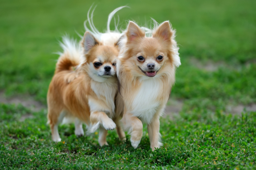

In [6]:
dest = 'data/chihuahua.jpg'
download_url(urls[0], dest)
im = Image.open(dest)
im.to_thumb(256, 256)

In [2]:
path = Path("data/dog_breeds")

In [ ]:
dog_breeds = [
    "Golden Retriever",
    "Dalmatian",
    "Pug",
    "Siberian Husky",
    "Dachshund",
    "Bulldog",
    "Poodle",
    "Chihuahua",
]


for o in dog_breeds:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

In [4]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

26

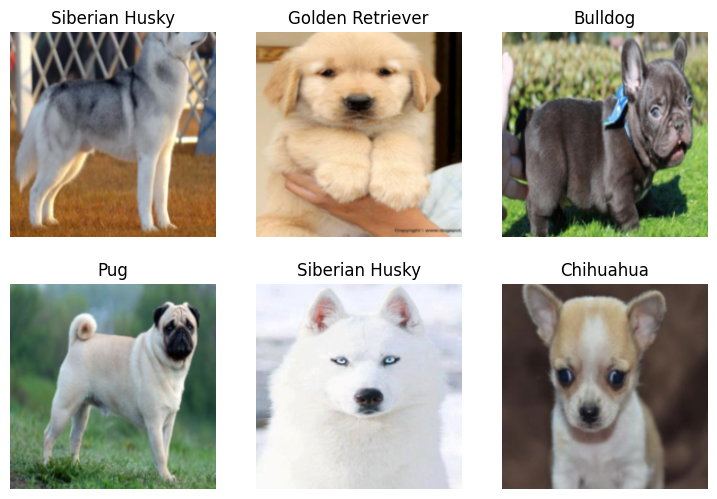

In [18]:
dls = DataBlock(blocks=(ImageBlock, CategoryBlock),
                get_items = get_image_files,
                splitter = RandomSplitter(valid_pct=0.2, seed=42),
                get_y = parent_label,
                item_tfms = [Resize(224, method='squish'), RandomResizedCrop(224, min_scale=0.8)]).dataloaders(path, bs=64)

dls.show_batch(max_n=6)

In [19]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(2)

epoch,train_loss,valid_loss,accuracy,time
0,1.181495,0.052289,0.988584,00:19


epoch,train_loss,valid_loss,accuracy,time
0,0.174969,0.030008,0.988584,00:21
1,0.086748,0.030008,0.986301,00:21


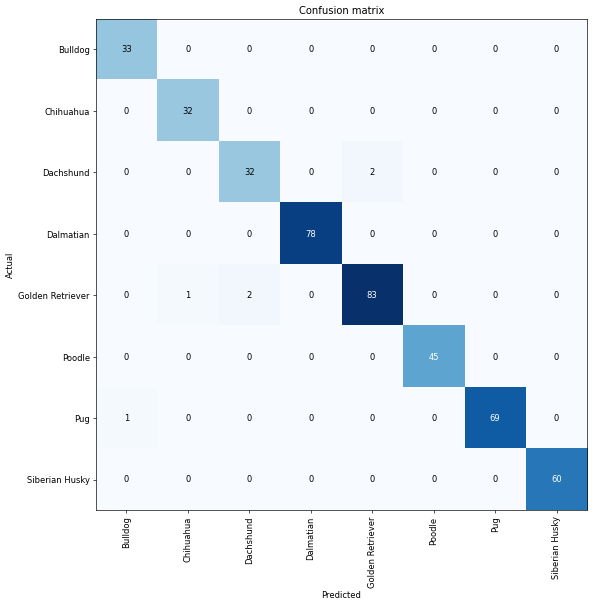

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)

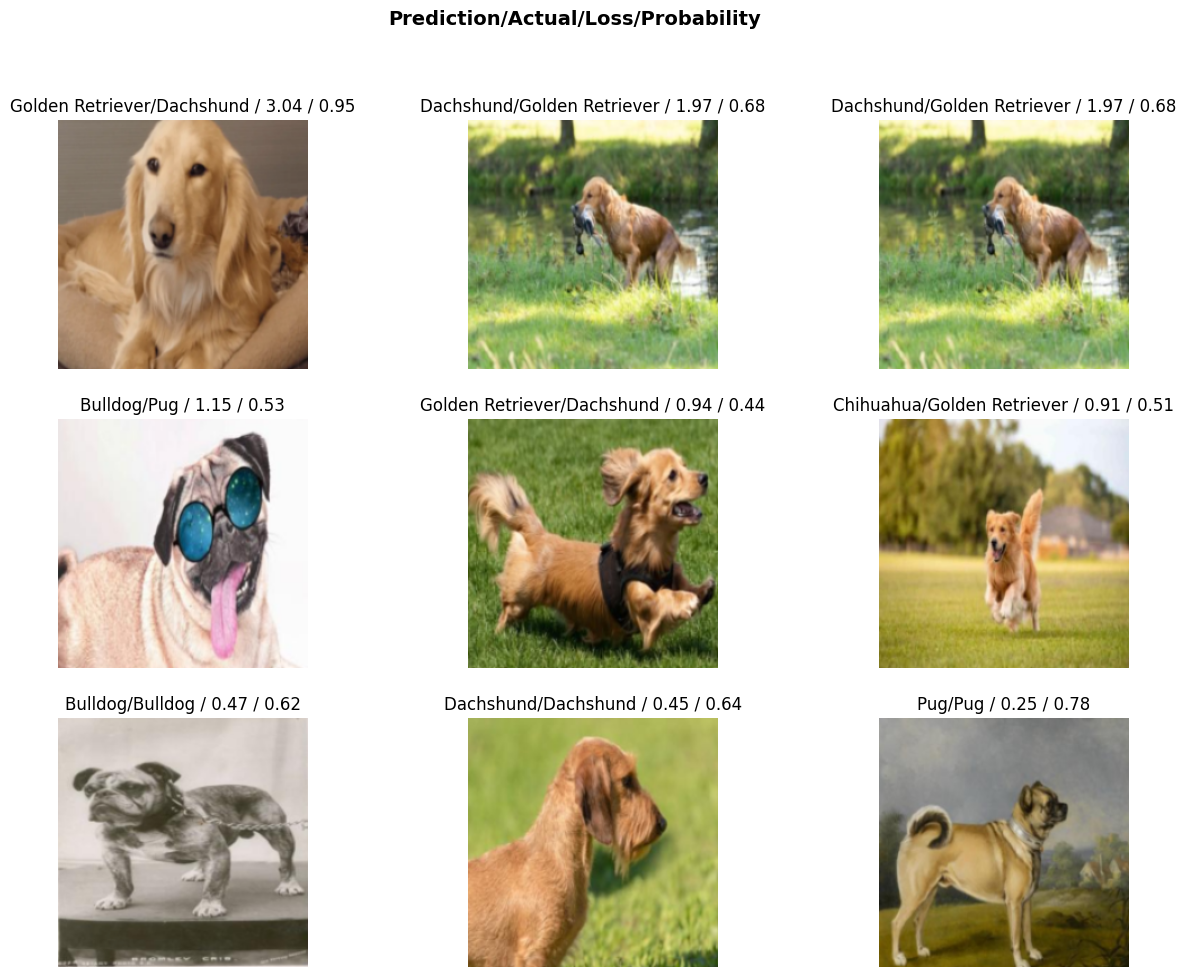

In [21]:
interp.plot_top_losses(9, figsize=(15,11))

In [16]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink() # delete the selected files

In [23]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat) # move files to the right folder/category

In [24]:
learn.export(path/'export.pkl') # export the model

In [26]:
learn_inf = load_learner('models/chapter1_2.pkl')

In [27]:
learn_inf.dls.vocab

['Bulldog', 'Chihuahua', 'Dachshund', 'Dalmatian', 'Golden Retriever', 'Poodle', 'Pug', 'Siberian Husky']

In [34]:
dog, _, probs = learn_inf.predict('data/chihuahua.jpg')

# Get the index of the predicted class
dog_index = learn_inf.dls.vocab.o2i[dog]

print(f"This is a: {dog}.")
print(f"Probability it's a {dog}: {probs[dog_index]:.4f}")

This is a: Chihuahua.
Probability it's a Chihuahua: 0.9999
